In [143]:
import os
import time
import torch
from torch import nn, optim
import sys
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import r2_score, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score


class FaceDataset(Dataset):
    def __init__(self, path, over_sample=False, augment=False):
        data = torch.tensor(pd.read_csv(path, header=None).values)
        y, X = data[:,0], data[:,1:]
        print(y.shape, X.shape)
        y = y.squeeze()
        
        self.X = X.float()
        self.y = y.long()
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    


    
def write_predictions(fname, arr):
    np.savetxt(fname, arr, fmt="%d", delimiter="\n")

    
    
    
train_data = FaceDataset('train.csv')
size = dataset.__len__()


torch.Size([19376]) torch.Size([19376, 2304])


In [160]:
class NNet(nn.Module):
    def __init__(self):
        super(NNet, self).__init__()
        self.fc1 = nn.Linear(2304, 100)
        self.fc2 = nn.Linear(100, 7)
        self.output = nn.Softmax(dim=1)
    
    def forward(self, x):
        #change various activations:[relu, tanh, leaky-relu, softmax] using F.relu, F.tanh....
        x = F.softmax(self.fc1(x), dim=1)
        x = self.fc2(x)
        return self.output(x)
    
    
batch_size = 64
train_data_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)

tic = time.time()
net = NNet()
net = net.to(device)
freq = np.bincount(train_data.y)
inv_freq = train_data.y.shape[0] / freq
inv_freq = 7 * inv_freq / inv_freq.sum()
print(inv_freq)


loss_function = nn.CrossEntropyLoss(weight=torch.tensor(inv_freq).float().cuda())
optimizer = optim.Adam(net.parameters(), lr=3e-4)

loss_log = []
max_epochs = 60
for epoch in range(max_epochs):

    for i, data in enumerate(train_data_loader, 0):
        images, classes = data
        images, classes = images.to(device), classes.to(device)

        optimizer.zero_grad()
        output = net(images)

        loss = loss_function(output, classes)
        loss_log.append(loss.item())
        loss.backward()
        optimizer.step()

    toe = time.time()
    if toe - tic > 500:
        break




[0.48423978 4.39427083 0.47052991 0.26640154 0.39413496 0.60265453
 0.38776844]


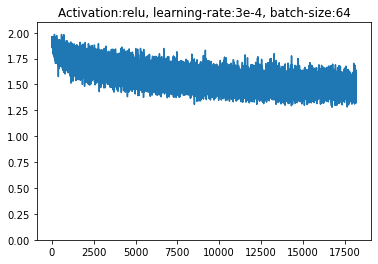

In [152]:
fig, ax = plt.subplots(1, 1)
ax.plot(loss_log)
ax.set_ylim(0, 2.1)
ax.set_title("Activation:relu, learning-rate:3e-4, batch-size:64")
#plt.savefig('plots/a/relu.png')

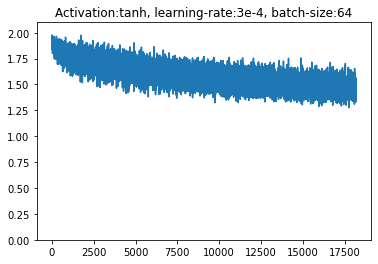

In [155]:
fig, ax = plt.subplots(1, 1)
ax.plot(loss_log)
ax.set_ylim(0, 2.1)
ax.set_title("Activation:tanh, learning-rate:3e-4, batch-size:64")
#plt.savefig('plots/a/tanh.png')

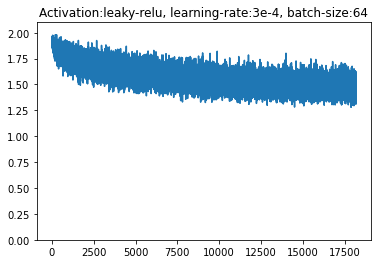

In [158]:
fig, ax = plt.subplots(1, 1)
ax.plot(loss_log)
ax.set_ylim(0, 2.1)
ax.set_title("Activation:leaky-relu, learning-rate:3e-4, batch-size:64")
#plt.savefig('plots/a/leaky-relu.png')

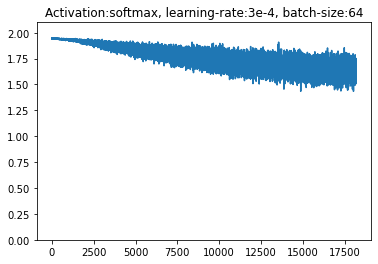

In [161]:
fig, ax = plt.subplots(1, 1)
ax.plot(loss_log)
ax.set_ylim(0, 2.1)
ax.set_title("Activation:softmax, learning-rate:3e-4, batch-size:64")
plt.savefig('plots/a/softmax.png')

In [162]:

test_dataset = FaceDataset('public_test.csv')
with torch.no_grad():
    test_loader = torch.utils.data.DataLoader(test_dataset, 1000, shuffle=False, num_workers=4)

    actual, prediction = [], []
    for i, data in enumerate(test_loader, 0):
        images, classes = data
        images, classes = images.to(device).float(), classes.to(device).long()
        #images, classes = images.float(), classes.long()
        actual.extend(classes.squeeze().tolist())

        optimizer.zero_grad()
        output = net(images)

        prediction.extend(torch.argmax(output, dim=1).squeeze().tolist())
        #print(output)

    print(accuracy_score(actual, prediction))
    print(f1_score(actual, prediction, average='macro'))
    print(confusion_matrix(actual, prediction))

torch.Size([6459]) torch.Size([6459, 2304])
0.37467100170305
0.33540345565484
[[291  20  43 168 143  51 176]
 [ 13  31   5  20  13   5  11]
 [158  20  67 149 178 146 201]
 [222  28  43 838 166  91 234]
 [240  31  41 148 303  62 272]
 [ 60  14  25  78  42 395 103]
 [130   9  33 186 173  88 495]]


In [163]:
#CNN analysis:

class FaceDataset(Dataset):
    def __init__(self, path, over_sample=False, augment=False):
        data = torch.tensor(pd.read_csv(path, header=None).values)
        y, X = data[:,0], data[:,1:]
        print(y.shape, X.shape)
        y = y.squeeze()
        
        self.X = X.reshape(-1, 1, 48, 48).float()
        self.y = y.long()
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=3, padding=0)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=2, padding=0)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = nn.Linear(in_features=512, out_features=256)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(in_features=256, out_features=7)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.pool2(x)
        
        x = x.view(-1, 512)
        x = F.relu(self.fc1(x))
        x = self.bn3(x)
        
        x = self.softmax(self.fc2(x))
        
        return x 

train_data = FaceDataset('train.csv')

torch.Size([19376]) torch.Size([19376, 2304])


In [165]:
batch_size = 64
train_data_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)

tic = time.time()
cnet = ConvNet()
cnet = cnet.to(device)

freq = np.bincount(train_data.y)
inv_freq = train_data.y.shape[0] / freq
inv_freq = 7 * inv_freq / inv_freq.sum()

loss_function = nn.CrossEntropyLoss(weight=torch.tensor(inv_freq).float().cuda())
optimizer = optim.Adam(cnet.parameters(), lr=1e-3)

loss_log = []
max_epochs = 50
for epoch in range(max_epochs):

    for i, data in enumerate(train_data_loader, 0):
        images, classes = data
        images, classes = images.to(device), classes.to(device)

        optimizer.zero_grad()
        output = cnet(images)

        loss = loss_function(output, classes)
        loss_log.append(loss.item())
        loss.backward()
        optimizer.step()

    toe = time.time()
    if toe - tic > 1700:
        break




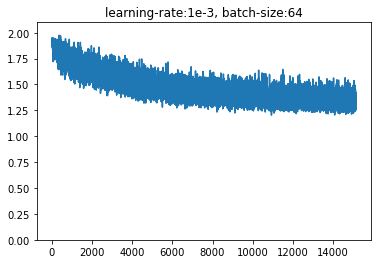

In [166]:
fig, ax = plt.subplots(1, 1)
ax.plot(loss_log)
ax.set_ylim(0, 2.1)
ax.set_title("learning-rate:1e-3, batch-size:64")
plt.savefig('plots/c/loss.png')

In [167]:
test_dataset = FaceDataset('public_test.csv')
with torch.no_grad():
    test_loader = torch.utils.data.DataLoader(test_dataset, 1000, shuffle=False, num_workers=4)

    actual, prediction = [], []
    for i, data in enumerate(test_loader, 0):
        images, classes = data
        images, classes = images.to(device).float(), classes.to(device).long()
        #images, classes = images.float(), classes.long()
        actual.extend(classes.squeeze().tolist())

        optimizer.zero_grad()
        output = cnet(images)

        prediction.extend(torch.argmax(output, dim=1).squeeze().tolist())
        #print(output)

    print(accuracy_score(actual, prediction))
    print(f1_score(actual, prediction, average='macro'))
    print(confusion_matrix(actual, prediction))

torch.Size([6459]) torch.Size([6459, 2304])
0.4172472518965784
0.39306016109185354
[[298  11  93 149 155  51 135]
 [ 11  32  13  15  11   4  12]
 [152   9 246 116 166 110 120]
 [167  17 105 929 166  66 172]
 [195  16 126 173 345  65 177]
 [ 42   6  78  60  48 422  61]
 [154  17 105 178 170  67 423]]


In [131]:
print(np.bincount(train_data.y))
freq = np.bincount(train_data.y)
inv_freq = train_data.y.shape[0] / freq
inv_freq = inv_freq * 5 / inv_freq.sum()
print(inv_freq)

[2677  295 2755 4866 3289 2151 3343]
[0.34588556 3.13876488 0.33609279 0.19028681 0.28152497 0.43046752
 0.27697746]
